In [13]:
#Used libraries
import csv
import re
import os
from brian2 import *
import numpy as np
from scipy.interpolate import interp1d
import brian2.numpy_ as np
import matplotlib.pyplot as plt
import time
import warnings
from scipy import interpolate
from keras.datasets import mnist
from tqdm import tqdm
import random
import pickle
from random import shuffle
import seaborn as sn
import pandas as pd
import pickle



## First step into MNIST problem - Vizualisation of states

project: Analog Spiking Neuron Model for Unsupervised STDP-based learning in Neuromorphic Circuits

This Jupyter notebook provides an interactive and visual exploration of the initial steps involved in training and testing an eSNN on the MNIST dataset. It is designed to help users understand and observe the state and variables throughout the training and testing processes.

'''
The code below implements unsupervised STDP-based learning within a eSNN
using complete model of a Morris-Lecar electronic neuron and conductance-based synapses.
The neuron model is derived from the post layout simulation results
of its analog circuit from Ferreira et al. (2019)

The training, labeling, and evaluation processes are inspired by the methodology of Diehl&Cook (2015).
To maintain effective unsupervised learning, training, labeling and testing are implemented as three distinct
functions. However a training function with continous labeling and testing is also feasible.

Here, the eSNN is tested on the MNIST benchmark dataset. 
The eSNN is trained with noiseless neurons (SCENARIO 3 in the paper)

This code employs the architecture : [784,100]+exci+inhi+wta.
It means that there is 784 input neurons fully connected with 100 outputs neurons
with both excitatory and inhibitory synapses conducted with STDP rules. Plus, there is a lateral inhibition
playing a soft-Winner-Take-All synaptic connection between output neurons. It implies 166700 synapses. 

'''

# Dataset

In [14]:
def load_mnist(nb_train, nb_test, working_range=8, batch_size_train=256, batch_size_test=50):
    print(" ATTENTION ! you're currently using a reduced mnist (only 0|1|2|3)")
    # Import the MNIST Database
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # simplified classification (0 1 3 4)
    X_train = X_train[(y_train == 1) | (y_train == 0) | (y_train == 3) | (y_train == 2)]
    y_train = y_train[(y_train == 1) | (y_train == 0) | (y_train == 3) | (y_train == 2)]
    X_test = X_test[(y_test == 1) | (y_test == 0) | (y_test == 3) | (y_test == 2)]
    y_test = y_test[(y_test == 1) | (y_test == 0) | (y_test == 3) | (y_test == 2)]

    # Make pixel intensity 255 become working_range*nA
    X_train = X_train * (working_range/255)
    X_test = X_test * (working_range/255)


    if nb_train >= len(X_train) or nb_train <= 0:
        nb_train = len(X_train)
    if nb_test >= len(X_test) or nb_test <= 0:
        nb_test = len(X_test)

    #Reduce the mnist-list for debbuging part
    X_train, X_test = X_train[:nb_train], X_test[:nb_test]
    y_train, y_test = y_train[:nb_train], y_test[:nb_test]

    X_train_batches, y_train_batches,X_test_batches, y_test_batches, nb_batch = shuffle_and_batch_data(X_train, y_train, X_test, y_test,batch_size_train,batch_size_test)
    
    return X_train_batches, y_train_batches, X_test_batches, y_test_batches,nb_batch



def shuffle_and_batch_data(X_train, y_train, X_test, y_test, batch_size_train,batch_size_test):
    # Combine the features and labels to shuffle them together
    combined_train = list(zip(X_train, y_train))
    np.random.shuffle(combined_train)
    X_train[:], y_train[:] = zip(*combined_train)
    
    combined_test = list(zip(X_test, y_test))
    np.random.shuffle(combined_test)
    X_test[:], y_test[:] = zip(*combined_test)
    
    # Calculate the total number of batches
    n_batches_train = len(X_train) // batch_size_train
    if len(X_train) % batch_size_train != 0:
        n_batches_train += 1
        
    # Calculate the total number of batches
    n_batches_test = len(X_test) // batch_size_test
    if len(X_test) % batch_size_test != 0:
        n_batches_test += 1
    
    # Divide the data into batches
    X_train_batches = np.array_split(np.array(X_train), n_batches_train)
    y_train_batches = np.array_split(np.array(y_train), n_batches_train)
    X_test_batches = np.array_split(np.array(X_test), n_batches_test)
    y_test_batches = np.array_split(np.array(y_test), n_batches_test)
    
    return X_train_batches, y_train_batches, X_test_batches, y_test_batches,n_batches_train

 ATTENTION ! you're currently using a reduced mnist (only 0|1|2|3)
len(y_train) =   60000
len(y_test) =   10000
X_train.shape, y_train.shape =  (10, 28, 28) (10,)
X_test.shape, y_test.shape =  (10, 28, 28) (10,)
For Training, with batch_size =  7  you got 2 batches of size : (5, 28, 28)
For Training, with batch_size =  7  you got 2 batches of size : (5, 28, 28)  
 



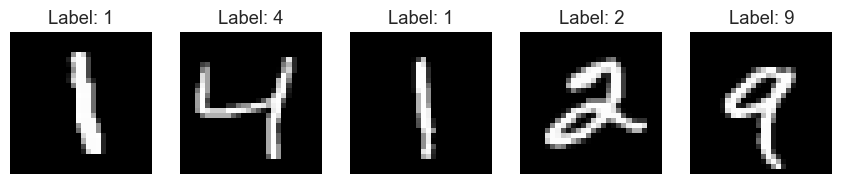

In [15]:
X_train_batches, y_train_batches, X_test_batches, y_test_batches,nb_batch = load_mnist(10, 10, working_range=8, batch_size_train=7, batch_size_test=7)

plt.figure(figsize=(15, 3)) 
for pos,(sample, label) in enumerate(zip(X_train_batches[0], y_train_batches[0])):    
    plt.subplot(1, 7, pos + 1)  
    plt.imshow(sample, cmap='gray')  
    plt.title(f'Label: {label}')  
    plt.axis('off') 

# The network

In [4]:
# Usuful function

def reducing_list(original_list, new_size):
    '''
        Function that reduces the size of a list and lessen the amount of computation
    In input:
        - Original_list: list you want to reduce in size
        - new_size: size desired for the list
    It returns:
        - Similar list with desired size
    '''
    original_size = len(original_list)
    if new_size >= original_size:
        return original_list  

    # Calculate the sampling interval
    interval = original_size / new_size

    # Sample elements at regular intervals
    new_list = [original_list[int(i * interval)] for i in range(new_size)]

    return new_list


def extracting_eNeuron_behavior(csv_file_path,nb_point_interpolation):
    '''
        Function that extrates data from the transfer function of th eNeuron ML in order to define a linear-
        interpolation function
    In input:
        - path of the csv file containing the transfer function of the eNeuron
        - nb_point_interpolation: size of the interpolated list
    It returns:
        - i_new: x-axis of the interpolated function (amp)
        - f_new: y-axs of the interpolated function (Hz)
    '''

    input_current = []
    spike_rate = []

    # Open the CSV file
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file, delimiter='\t')
        next(csv_reader)
        for row in csv_reader:
            values = re.split(r',', row[0])
            input_current.append(float(values[0]))
            spike_rate.append(float(values[1]))

    prefs.codegen.target = 'numpy'
    i_new = reducing_list(input_current,nb_point_interpolation)
    f_new = reducing_list(spike_rate,nb_point_interpolation)

    # Convert data to use with Brian2
    i_new = i_new * amp
    f_new = f_new * Hz
    
    return i_new, f_new


def save_accuracy_txtfile(filename, n_output, n_epoch,accuracy_max,accuracy):
    '''
        Function that saves accuracy results to a text file
    '''
    with open(filename, 'a') as file:
        file.write(f"\n Method unsupervised with  {n_output} output neurons: \n")
        file.write(f" It has taken "+ str(n_epoch) +f" epoch for reaching {accuracy_max*100} '%' accuracy \n")
        file.write(" The three observed accuracy are are the end of the training = ")
        accuracy_str = np.array_str(accuracy)
        file.write(accuracy_str)
        file.write("\n")
        file.write("\n")
        
def weight_evolution(weight_evol_exci,weight_evol_inhi,n_output):
    ''''
        Function that display a graph of the evolution of the synaptic weights conducted by STDP rules.
        It plots some random synaptic weights because it's not possible to vizualize all of them.
    In input:
        - 2 lists of the evolution of the synaptic weights conducted by STDP rules 
        - n_output: number of neurons on the output layer
    It returns:
        - Nothing, it plots the graph
    '''
    random_idx_weight = [random.randint(0, len(weight_evol_exci[0])-1) for _ in range(50)]
    
    plt.figure(figsize=(10, 6)) 
    plt.subplot(1, 2, 1)  
    for idx_w in random_idx_weight:
        weight = [ligne[idx_w] for ligne in weight_evol_exci]
        plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  
    plt.title('Evolution des poids synaptiques EXCI ')
    plt.xlabel(f' epoch ')
    plt.ylabel(' weight [0,1]')
    #plt.ylim(-wmax-1, wmax+1) 
    plt.grid(True)
    #plt.legend()

    plt.subplot(1, 2, 2)
    for idx_w in random_idx_weight:
        weight = [ligne[idx_w] for ligne in weight_evol_inhi]
        plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  
    plt.title('Evolution des poids synaptiques INHI ')
    plt.xlabel(f' epoch ')
    plt.ylabel(' weight [0,1]')
    plt.grid(True)
    #plt.legend()
    plt.show()

    #plt.savefig(f"{directory}/weight_evolution_epoch_{n_output}output.png")
    
    
def plot_accuracy_evol(accuracy_evol,n_output):
    ''''
        Function that display a graph of the average evolution of the accuracies 
    In input:
        - list of the accuracies evolution
        - n_output: number of neurons on the output layer
    It returns:
        - Nothing, it saves and plots the graph if plot==True
    '''
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(len(accuracy_evol)),accuracy_evol,label="max criteria")
    plt.title(' accuracy evolution ')
    plt.xlabel(f' epoch  ')
    plt.ylabel(' accuracy ')
    plt.grid(True)
    plt.legend()
    plt.show()
    #plt.savefig(f"unsupervised_v3_images/accuracy_evol_epoch_{n_output}output.png")


In [5]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

# Simulation parameters
defaultclock.dt = 0.005*us  
time_per_sample = 100 * us
resting_time = 20 * us

# Defining the linear interpolation of the eNeuron ML behavior
i_new, f_new = extracting_eNeuron_behavior(csv_file_path='FT_augmented.csv',nb_point_interpolation=1111)
interp_function = interp1d(i_new, f_new, fill_value='extrapolate')

@check_units(x=amp, result = Hz)
def y_interp_function(x):
    return interp_function(x)*Hz

#Model parameters
v_rest = -80*mV
v_threshold = 60*mV  
v_std_thresh = 0*mV #standart deviation for the threshold value (randn :drawn from the standard normal distribution, i.e. with mean 0 and standard deviation 1) 
v_reset = -100*mV
v0 = -40*mV  
tau = 500*us
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp

a_v = 1126.6343973469338
b_v = 169200.45773494235
a_value = 6.23667974e13

x_threshold_v= 8.3e-11*amp
q, R_ds,C_m = 1.6*1e-19*amp*second, 5*ohm, 5*1e-8*second/ohm
avoid_error = 0.01*pA
frequency_min = 0.1*Hz
refrac = 0*us
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
avoid_error = 0.01*pA


# This model use a constant Resistance and a log approximation
neuron_eqs_v1 = '''
dv/dt =  (v_rest - v) / tau2 + (( int(I_total > x_threshold_v) *((a_v + b_v * log((1-int(I_total > x_threshold_v))+int(I_total > x_threshold_v)*(I_total+avoid_error)/(x_threshold_v) ))*I0)/a_value)*Rm) / tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 12*nA) : amp
Ie =  alpha_e*ge * uS *(80*mV -v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1

threshold = v_threshold + int(noise_activity)*v_std_thresh*randn() : volt (constant over dt)
noise_activity : boolean (shared) # (un)Activate the noise
'''

reset_eqs = '''
v = v_reset
'''



#STDP parameters
tau_stdp = 3.88116837
mag_stdp = 0.007070372048
mag_stdp = 0.002370372048


taupre = tau_stdp*us
taupost = taupre
wmax = 1
dApre = mag_stdp
dApost = -dApre * taupre / taupost * 1.05

stdp_eqs_exci = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_exci='''
    ge_post += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, wmax)
'''
post_eqs_exci='''
    Apost += dApost
    w = clip(0.999*w + lr*Apre, 0, wmax)
'''

stdp_eqs_inhi = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_inhi='''
    gi_post += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, wmax)
'''
post_eqs_inhi='''
    Apost += dApost
    w = clip(0.999*w + lr*Apre, 0, wmax)
'''

synapse_model = "w : 1"



n_input, n_output = 28*28,100

class SNN_eNeuron():
    def __init__(self, debug=False):
        '''
            Initialization including setting up neuron groups and synapses
        '''

        from brian2 import clear_cache
        from brian2 import device
        device.reinit()
        start_scope()

        # Simulation parameters
        defaultclock.dt = 0.008*us  

        model = {}

        model['input'] = NeuronGroup(N=n_input, model=neuron_eqs_v1, threshold='v >= threshold', reset=reset_eqs, refractory='refrac', method='heun',name='input')
        model['input'].noise_activity = False

        model['output'] = NeuronGroup(N=n_output, model=neuron_eqs_v1, threshold='v >= threshold', reset=reset_eqs, refractory='refrac', method='heun',name='output')
        model['output'].noise_activity = False

        model['input_synapse_exci'] = Synapses(model['input'], model['output'], model=stdp_eqs_exci, on_pre=pre_eqs_exci, on_post=post_eqs_exci,name='input_synapse_exci')
        model['input_synapse_exci'].connect(True)
        model['input_synapse_exci'].lr = 0.5
        model['input_synapse_exci'].w = 'rand() * wmax * 0.8 + 0.1*wmax'
        model['input_synapse_exci'].delay = 'rand()*0*us'

        model['input_synapse_inhi'] = Synapses(model['input'], model['output'], model=stdp_eqs_inhi, on_pre=pre_eqs_inhi, on_post=post_eqs_inhi,name='input_synapse_inhi')
        model['input_synapse_inhi'].connect(True)
        model['input_synapse_inhi'].lr = 0.5
        model['input_synapse_inhi'].w = 'rand() * wmax * 0.8 + 0.1*wmax'
        model['input_synapse_inhi'].delay = 'rand()*0*us'

        model['wta_synapse'] = Synapses(model['output'], model['output'], model=synapse_model, on_pre='gi_post += w',name='wta_synapse')
        model['wta_synapse'].connect(condition='i != j')
        model['wta_synapse'].w = 'rand() * wmax * 1.2 + 0.8*wmax'
        model['wta_synapse'].delay = 'rand()*0*us'

        model['output_SP'] = SpikeMonitor(model['output'], record= False,name='output_SP')
        
        
        if (debug):
            model['input_SP'] = SpikeMonitor(model['input'], record=True,name='input_SP')
            model['output_SP'] = SpikeMonitor(model['output'], record=True,name='output_SP')

        print("You've created :",len(model['input_synapse_exci'])+len(model['input_synapse_inhi'])+len(model['wta_synapse']) , "synapses in your network \n \n")

        self.net = Network(model)
        
        self.weight_evol_exci = []
        self.weight_evol_inhi = []
        self.weight_epoch_exci = []
        self.weight_epoch_inhi= []


    def __getitem__(self,key):
        return self.net[key]

    def training(self,idx_epoch,X_train,y_train,noise=True,plot=False):
        '''
            Training function with synaptic normalization and weight observation
        '''

        # (un)Activate noise during training
        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        self.net['input_synapse_exci'].lr = 1
        self.net['input_synapse_inhi'].lr = 1

        for j, (sample, label) in enumerate(zip(X_train, y_train)):

            self.net['input'].I = sample.ravel() * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            # Start the training simulation
            #self.net.run(time_per_sample, report='text', report_period = 60*second)
            self.net.run(time_per_sample)

            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest


            # NORMALISATION :
            weight_matrix = np.zeros([n_input, n_output])
            weight_matrix[self.net['input_synapse_exci'].i, self.net['input_synapse_exci'].j] = self.net['input_synapse_exci'].w
            sumCol = np.sum(weight_matrix, axis=0)
            colFactors = 70/sumCol
            for jj in range(n_output):
                weight_matrix[:,jj] *= colFactors[jj]
            self.net['input_synapse_exci'].w = weight_matrix[self.net['input_synapse_exci'].i, self.net['input_synapse_exci'].j]
            self.weight_epoch_exci.append(weight_matrix.T)
            print(" weight_matrix = ",weight_matrix[0,0])

            weight_matrix = np.zeros([n_input, n_output])
            weight_matrix[self.net['input_synapse_inhi'].i, self.net['input_synapse_inhi'].j] = self.net['input_synapse_inhi'].w
            sumCol = np.sum(weight_matrix, axis=0)
            colFactors = 35/sumCol
            for jj in range(n_output):
                weight_matrix[:,jj] *= colFactors[jj]
            self.net['input_synapse_inhi'].w = weight_matrix[self.net['input_synapse_inhi'].i, self.net['input_synapse_inhi'].j]
            self.weight_epoch_inhi.append(weight_matrix.T)
            
            #Observation weight evolution
            weight = [self.net['input_synapse_exci'].w[i] for i in range(len(self.net['input_synapse_exci'].w))]
            self.weight_evol_exci.append(weight)
            weight = [self.net['input_synapse_inhi'].w[i] for i in range(len(self.net['input_synapse_inhi'].w))]
            self.weight_evol_inhi.append(weight)
            
            start_time = idx_epoch*2000 * us  
            
            input_mask = (self.net['input_SP'].t >= start_time)
            output_mask = (self.net['output_SP'].t >= start_time)
            
            if j >= 4 and j<5 and idx_epoch <10 and plot:
                plt.figure(figsize=(20, 10)) 
                plt.plot(self.net['input_SP'].t[input_mask] / us, self.net['input_SP'].i[input_mask], '.b', label='input')
                plt.plot(self.net['output_SP'].t[output_mask] / us, self.net['output_SP'].i[output_mask], '.r', label='output')

                plt.ylabel('Neuron index')
                plt.xlabel('time (us)')
                plt.title("raster plot")
                plt.legend()
                plt.show()
                
    def labelisation(self,idx_epoch,X_train,y_train,noise=True,plot=False):
        '''
            Function for labeling output neurons based on their response to inputs
        '''

        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        # Desactivate STDP plasticity
        self.net['input_synapse_exci'].lr = 0
        self.net['input_synapse_inhi'].lr = 0

        spikes = np.zeros((10, n_output))

        old_spike_counts = np.zeros(n_output)
        old_spike_counts = np.copy(self.net['output_SP'].count)

        label_percent = 0.7 #40% of the previous trained data will be re-used to label output neurons
        nb_label = int(label_percent*len(y_train))
        X_labeling = X_train[nb_label:]
        y_labeling = y_train[nb_label:]


        for j, (sample, label) in enumerate(zip(X_labeling, y_labeling)):

            self.net['input'].I = sample.ravel() * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            # Start the simulation
            self.net.run(time_per_sample)
            counter_spike = self.net['output_SP'].count - old_spike_counts
            spikes[int(label)] += counter_spike    

            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            old_spike_counts = np.copy(self.net['output_SP'].count)

            #Observation weight evolution
            if idx_epoch != -1:
                weight = [self.net['input_synapse_exci'].w[i] for i in range(len(self.net['input_synapse_exci'].w))]
                self.weight_evol_exci.append(weight)
                weight = [self.net['input_synapse_inhi'].w[i] for i in range(len(self.net['input_synapse_inhi'].w))]
                self.weight_evol_inhi.append(weight)


        if plot:
            plt.figure()
            for i in range(len(spikes)):
                if spikes[i].any() != np.zeros(len(spikes[i])).any():
                    plt.plot(range(len(spikes[i])),spikes[i], label=f'label {i}')
            plt.ylabel('number of spikes')
            plt.xlabel('index of the output neurons')
            plt.title(" Spiking differenciation on the output layer ")
            plt.legend()
            plt.show()
        
        
        labeled_neurons = np.argmax(spikes, axis=0)
        redundancy_neuron = np.bincount(labeled_neurons, minlength=2)
        if plot:
            plt.figure()
            bar(range(len(redundancy_neuron)),redundancy_neuron)
            xticks(range(len(redundancy_neuron)))
            plt.xlabel('index outputs')
            plt.ylabel('number of labeled neurons')
            plt.title(" Labelisation the output layer ")
            plt.legend()
            plt.show()
            print(" labeled_neurons = ", labeled_neurons)
            print(" redundancy_neuron = ", redundancy_neuron)
        
        self.labeled_neurons = labeled_neurons
        self.redundancy_neuron = redundancy_neuron

        
    def intermediate_evaluation(self,idx_epoch,X_test,y_test,noise=True,plot=False):
        '''
            Evaluation function that tests the trained network on test data and calculate accuracy
        '''
        # Activate the noise
        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        # Desactivate STDP plasticity
        self.net['input_synapse_exci'].lr = 0
        self.net['input_synapse_inhi'].lr = 0

        spikes = np.zeros((10, n_output))

        old_spike_counts = np.zeros(n_output)
        old_spike_counts = np.copy(self.net['output_SP'].count)

        num_correct_output_max = 0
      
        for j, (sample, label) in enumerate(zip(X_test, y_test)):
            self.net['input'].I = sample.ravel() * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            # Start the simulation
            self.net.run(time_per_sample)
            counter_spike = self.net['output_SP'].count - old_spike_counts
            spikes[int(label)] += counter_spike    
            
            # Prediction of the SNN post labelisation
            output_label_max = self.labeled_neurons[np.argmax(counter_spike)]

            # Check prediction of the class of the sample
            if j < 8:
                pass
                print("output_label_max = ", output_label_max, " and int(label) = ", int(label))
            if output_label_max == int(label):
                num_correct_output_max += 1
        
            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            old_spike_counts = np.copy(self.net['output_SP'].count)


        accuracy_max = (num_correct_output_max / len(X_test))

        if plot:
            plt.figure()
            for i in range(len(spikes)):
                if spikes[i].any() != np.zeros(len(spikes[i])).any():
                    plt.plot(range(len(spikes[i])),spikes[i], label=f'label {i}')
            plt.ylabel('number of spikes')
            plt.xlabel('index of the output neurons')
            plt.title(" Spiking differenciation on the output layer ")
            plt.legend()
            plt.show()
    
        weight_wta = np.zeros((n_output*(n_output-1)))
        weight_wta = np.copy(self.net['wta_synapse'].w)
        
        return accuracy_max, self.weight_evol_exci, self.weight_evol_inhi,self.weight_epoch_exci,self.weight_epoch_inhi,self.labeled_neurons,spikes,weight_wta
    
    def final_evaluation(self,idx_epoch,X_test,y_test,noise=True,plot=False):
        '''
            Final evaluation post training: function that tests the trained network on test data and calculate accuracy
        '''
        # Activate the noise
        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        # Desactivate STDP plasticity
        self.net['input_synapse_exci'].lr = 0
        self.net['input_synapse_inhi'].lr = 0
        
        #print(" self.net['wta_synapse'].w = ", self.net['wta_synapse'].w)

        spikes = np.zeros((10, n_output))

        old_spike_counts = np.zeros(n_output)
        old_spike_counts = np.copy(self.net['output_SP'].count)

        num_correct_output_max = 0
        confusion_matrix = np.zeros(100).reshape(10,10)
      
        for j, (sample, label) in enumerate(zip(X_test, y_test)):
            self.net['input'].I = sample.ravel() * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            # Start the simulation
            self.net.run(time_per_sample)
            counter_spike = self.net['output_SP'].count - old_spike_counts
            spikes[int(label)] += counter_spike    
            
            # Prediction of the SNN post labelisation
            output_label_max = self.labeled_neurons[np.argmax(counter_spike)]

            # Check prediction of the class of the sample
            if j < 8:
                pass
                print("output_label_max = ", output_label_max, " and int(label) = ", int(label))
            if output_label_max == int(label):
                num_correct_output_max += 1
            confusion_matrix[int(label)][output_label_max] +=1
        
            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            old_spike_counts = np.copy(self.net['output_SP'].count)


        accuracy_max = (num_correct_output_max / len(X_test))


        return accuracy_max,confusion_matrix
    

 ATTENTION ! you're currently using a reduced mnist (only 0|1|2|3)
len(y_train) =   24754
len(y_test) =   4157
X_train.shape, y_train.shape =  (5000, 28, 28) (5000,)
X_test.shape, y_test.shape =  (500, 28, 28) (500,)
For Training, with batch_size =  20  you got 250 batches of size : (20, 28, 28)
For Training, with batch_size =  5  you got 100 batches of size : (5, 28, 28)  
 

You've created : 166700 synapses in your network 
 

 STARTING MNIST_training: 

 weight_matrix =  0.13407420899218772
 weight_matrix =  0.1349688787247367
 weight_matrix =  0.13496887872473678
 weight_matrix =  0.1344622925698426
 weight_matrix =  0.134794415227118


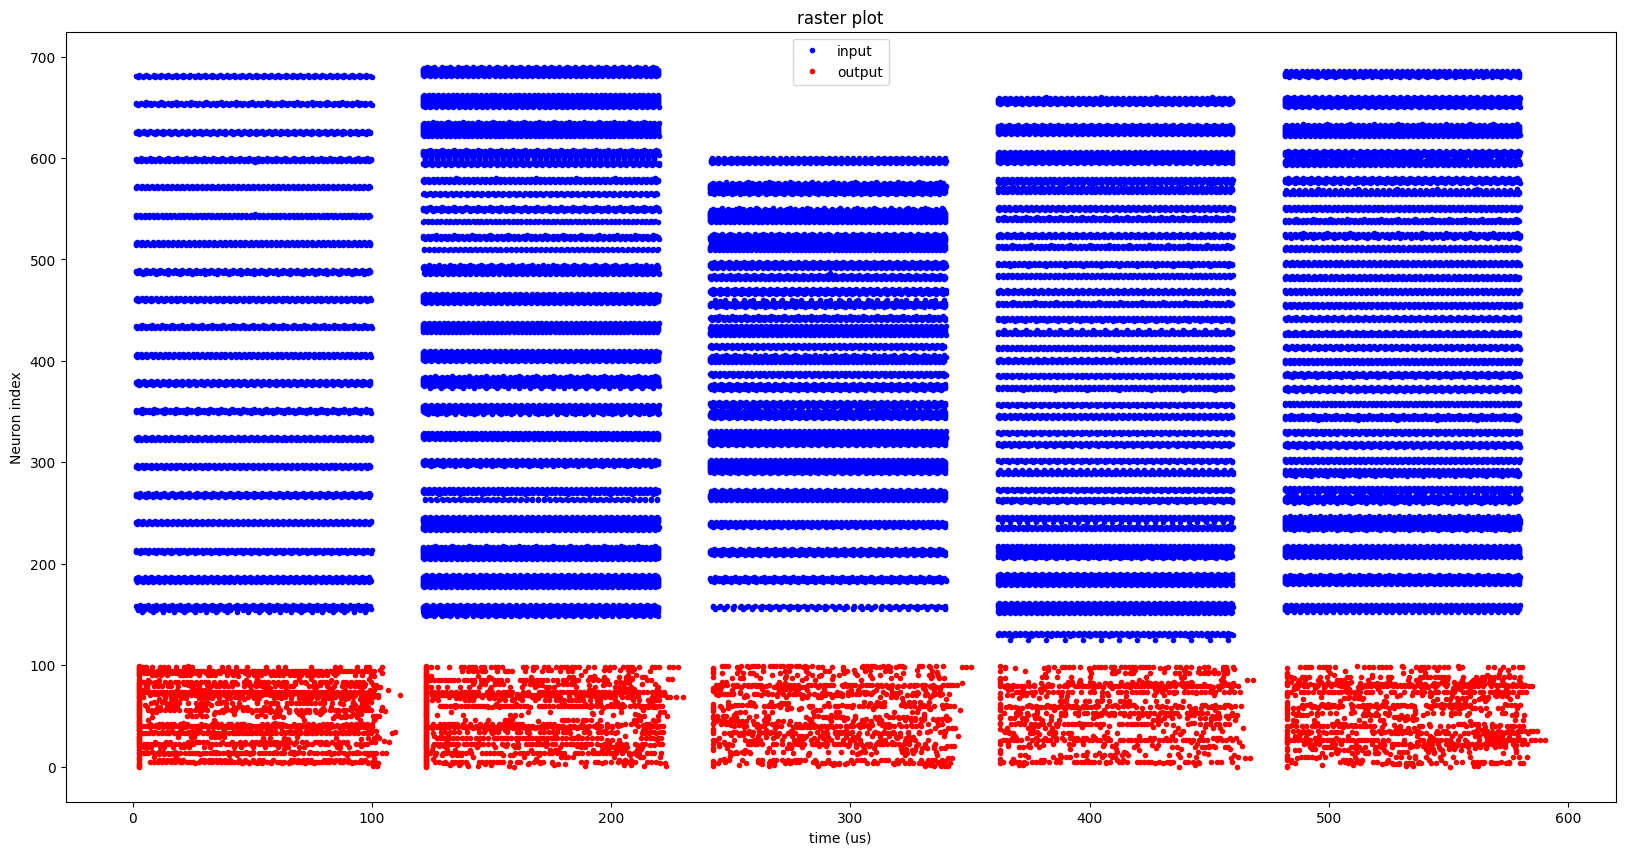

 weight_matrix =  0.13479441522711907
 weight_matrix =  0.134794415227119
 weight_matrix =  0.134794415227119
 weight_matrix =  0.13518911308148254
 weight_matrix =  0.13550882862001046
 weight_matrix =  0.13602275619544232
 weight_matrix =  0.13625241431861312
 weight_matrix =  0.13655975325839365
 weight_matrix =  0.13647361056998855
 weight_matrix =  0.1364736116634117
 weight_matrix =  0.13690154435361576
 weight_matrix =  0.1369015443536155
 weight_matrix =  0.1369015443536155
 weight_matrix =  0.13713280768399302
 weight_matrix =  0.13759974121977234
output_label_max =  0  and int(label) =  1
output_label_max =  0  and int(label) =  2
output_label_max =  0  and int(label) =  2
output_label_max =  0  and int(label) =  2
output_label_max =  2  and int(label) =  2
ACCURACY =  0.2
 FNISH epoch  0  in  1063.658573627472 s 

 weight_matrix =  0.13767775106705876
 weight_matrix =  0.1380021429065095
 weight_matrix =  0.1382288637067969
 weight_matrix =  0.1382288637067971
 weight_matrix

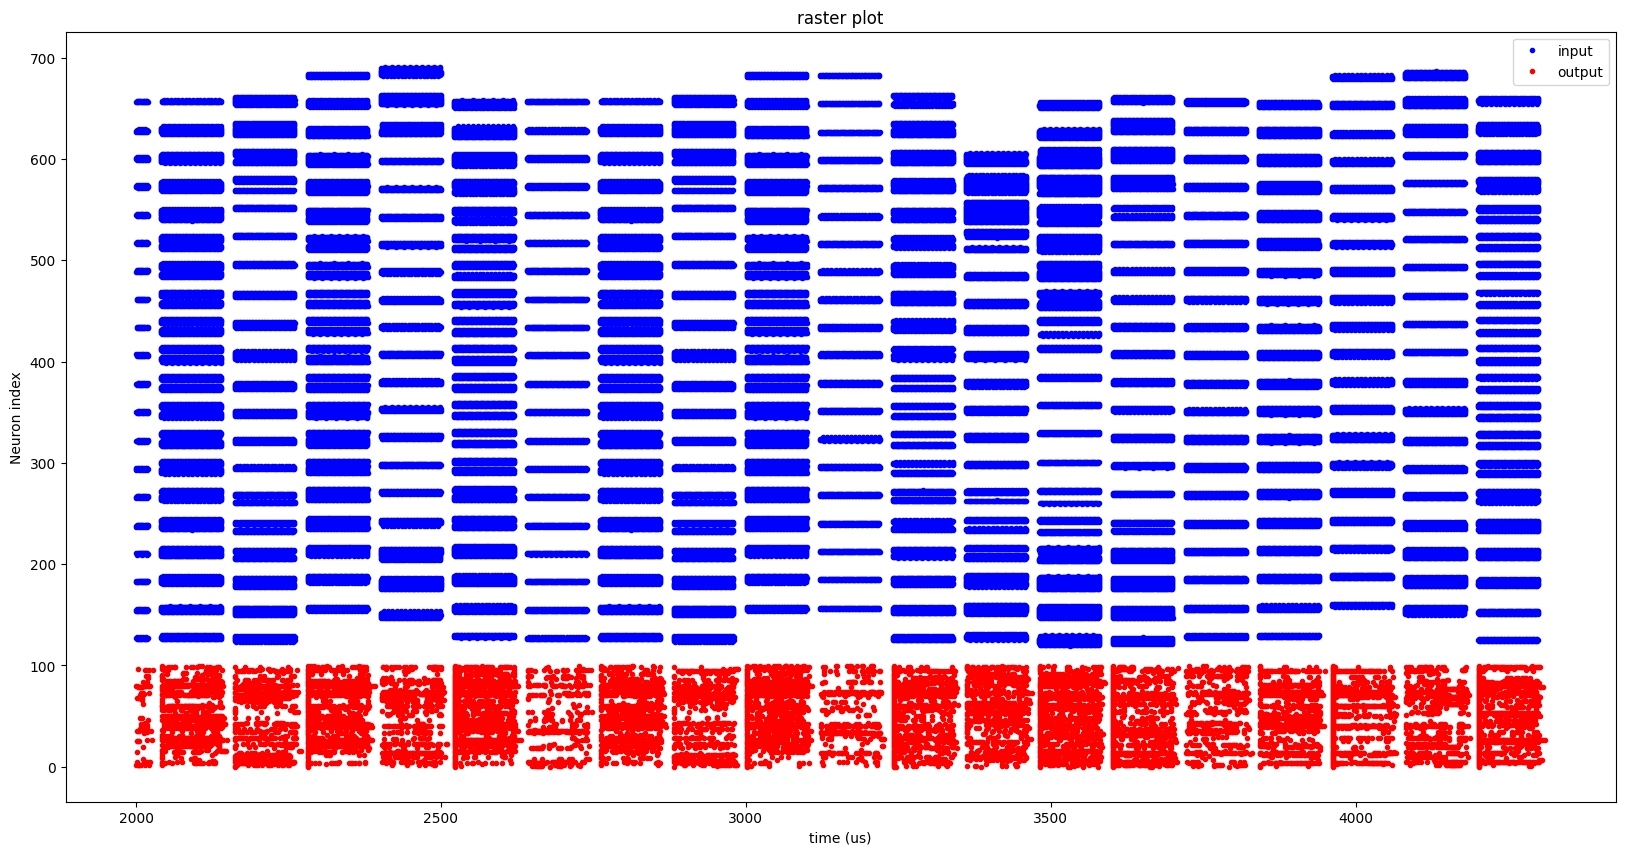

 weight_matrix =  0.13891467806273144
 weight_matrix =  0.1391964174116399
 weight_matrix =  0.13919641741163993
 weight_matrix =  0.13919641741163993
 weight_matrix =  0.13941680820044208
 weight_matrix =  0.13965282697463918
 weight_matrix =  0.14017518001129936
 weight_matrix =  0.14048821713022092
 weight_matrix =  0.14093347858286284
 weight_matrix =  0.1409334785828628
 weight_matrix =  0.1413870915628998
 weight_matrix =  0.1413870915628997
 weight_matrix =  0.1416878445627487
 weight_matrix =  0.14212178995312008
 weight_matrix =  0.14253858447884768
output_label_max =  2  and int(label) =  0
output_label_max =  3  and int(label) =  1
output_label_max =  3  and int(label) =  2
output_label_max =  3  and int(label) =  2
output_label_max =  3  and int(label) =  2
ACCURACY =  0.0
 FNISH epoch  1  in  1088.8229203224182 s 

 weight_matrix =  0.1425385844788729
 weight_matrix =  0.14281024899850994
 weight_matrix =  0.1428102489985109
 weight_matrix =  0.14281024899851097
 weight_ma

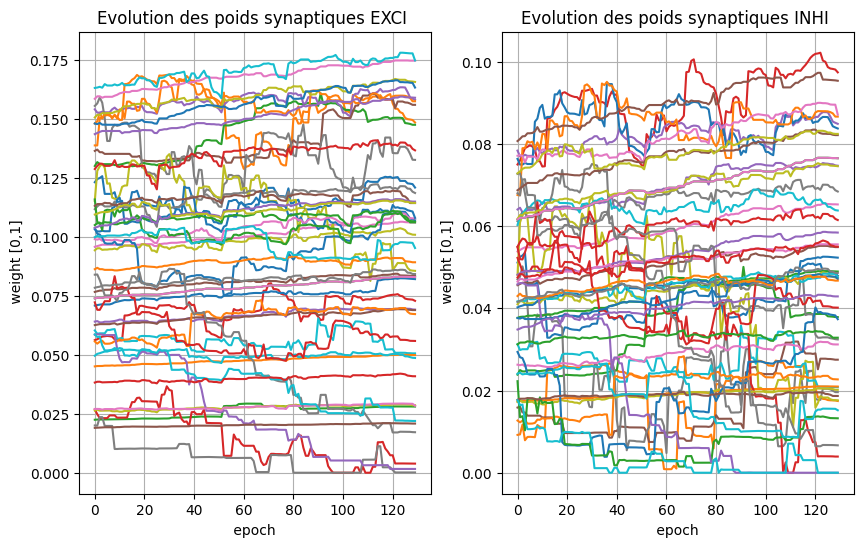

 accuracy_evol =  [0.2, 0.0, 0.8, 0.6, 0.6]


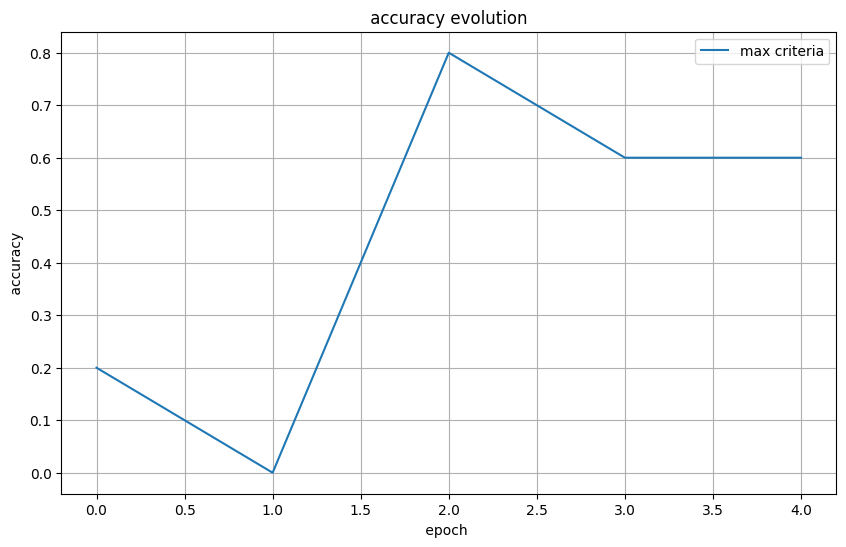

In [6]:
directory = 'mnist_backup'
    
noise=False

os.makedirs(directory,exist_ok=True)
accuracy_evol = []

# Importing mnist data
X_train_batches, y_train_batches, X_test_batches, y_test_batches, nb_batch = load_mnist(nb_train=5000, nb_test=500, working_range=3, batch_size_train=20,batch_size_test=5)

# Creating the SNN model
debug = True
model = SNN_eNeuron(debug=debug) 

epoch_max = 5
epoch_max = min(epoch_max, nb_batch)

print(" STARTING MNIST_training: \n")

#model.labelisation(-1,X_train_batches[-1], y_train_batches[-1],noise=noise,plot=debug)
#accuracy_max,weight_evol_exci,weight_evol_inhi,weight_epoch_exci,weight_epoch_inhi,labeled_neurons,spikes,weight_wta = model.intermediate_evaluation(-1,X_test_batches[-1], y_test_batches[-1],noise=True,plot=debug)
#accuracy_evol.append(accuracy_max)
#print("accuracy = ", accuracy_max)

tic = time.time()
#Training and Assesing
for idx_epoch in range(epoch_max):

    model.training(idx_epoch,X_train_batches[idx_epoch], y_train_batches[idx_epoch],noise=noise,plot=debug)
    model.labelisation(idx_epoch,X_train_batches[idx_epoch], y_train_batches[idx_epoch],noise=noise,plot=False)

    accuracy_max,weight_evol_exci,weight_evol_inhi,weight_epoch_exci,weight_epoch_inhi,labeled_neurons,spikes,weight_wta = model.intermediate_evaluation(idx_epoch,X_test_batches[idx_epoch], y_test_batches[idx_epoch],noise=True,plot=False)
    accuracy_evol.append(accuracy_max)
    print("ACCURACY = ", accuracy_max)
    print(" FNISH epoch ", idx_epoch," in ",time.time()-tic, "s \n")
    tic = time.time()
    if accuracy_max >= 0.85:
        break

itera = 1
if True:
    # Plot weight evolution
    weight_evolution(weight_evol_exci,weight_evol_inhi,n_output)

save_accuracy_txtfile(f"{directory}/Accuracy_nb_epoch_save.txt", n_output, idx_epoch+1, accuracy_max,np.array([accuracy_max]))
print(" accuracy_evol = ", accuracy_evol)
# Plot accuracy evolution
plot_accuracy_evol(accuracy_evol,n_output)




# Analysis

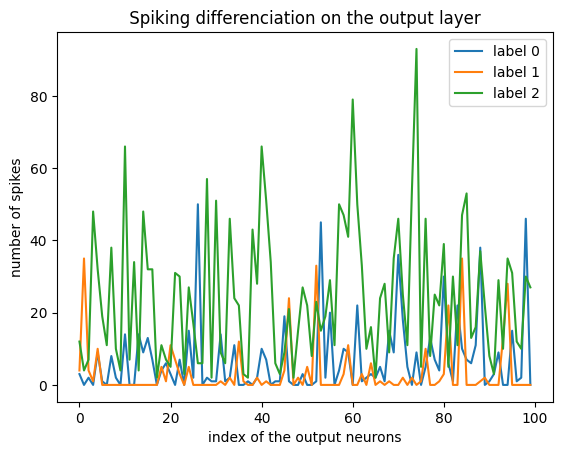

Text(0.5, 1.0, ' Labelisation the output layer ')

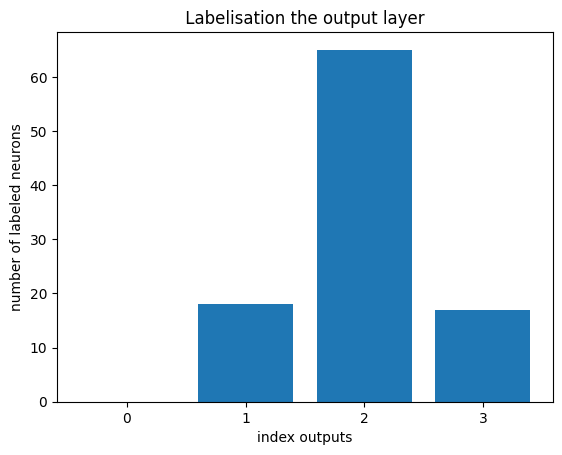

In [7]:
plt.figure()
for i in range(len(spikes)):
    if spikes[i].any() != np.zeros(len(spikes[i])).any():
        plt.plot(range(len(spikes[i])),spikes[i], label=f'label {i}')
plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.title(" Spiking differenciation on the output layer ")
plt.legend()
plt.show()
            
plt.figure()
redundancy_neuron = np.bincount(labeled_neurons, minlength=4)
bar(range(len(redundancy_neuron)),redundancy_neuron)
xticks(range(len(redundancy_neuron)))
plt.xlabel('index outputs')
plt.ylabel('number of labeled neurons')
plt.title(" Labelisation the output layer ")

blue means inhibitatory synapses && red means excitatory synapses 


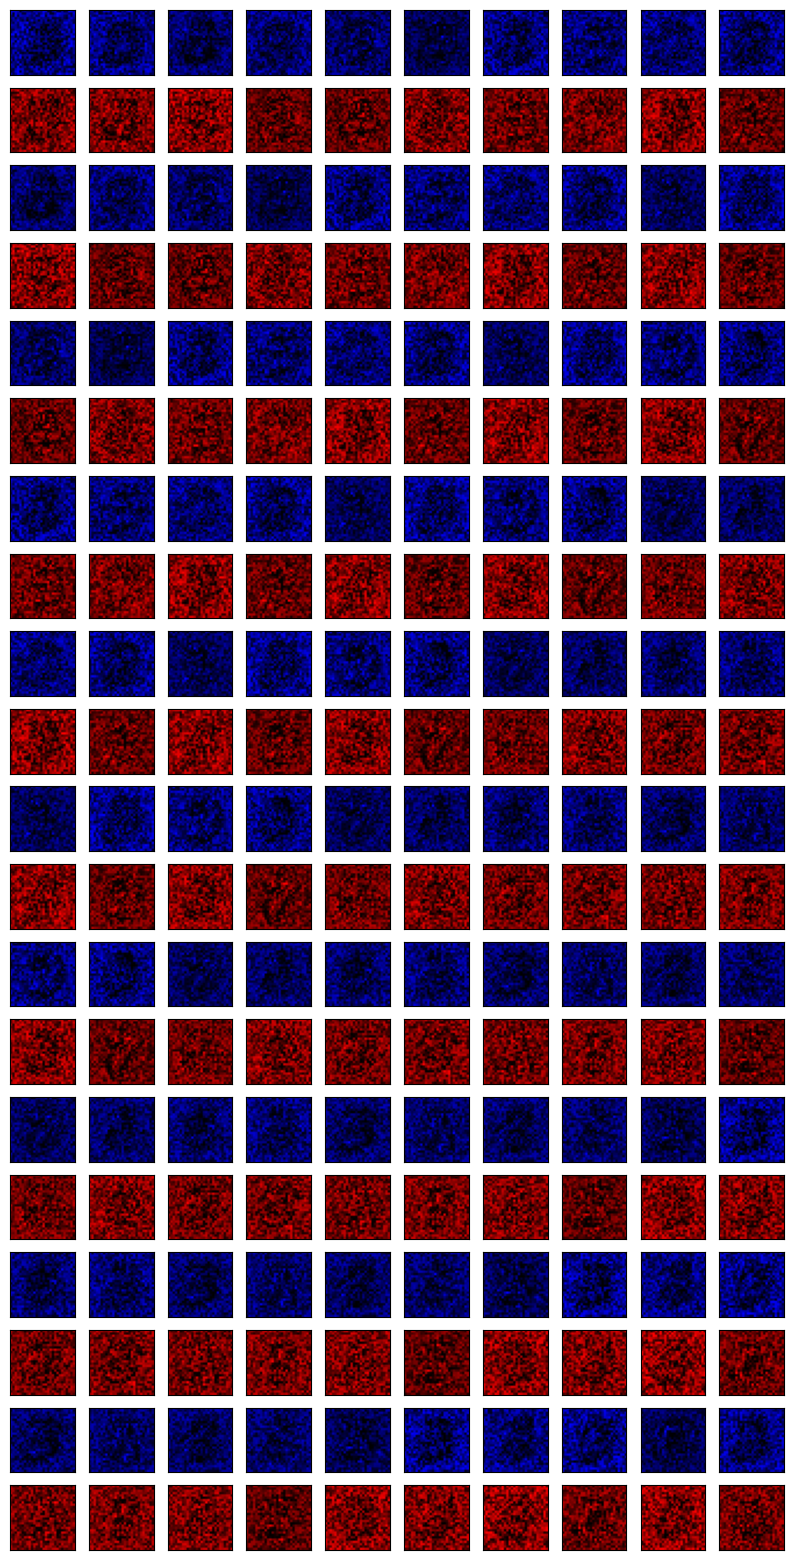

In [8]:
def apply_color_mask(gray_image1,color):
    # Normalisation of the weight
    normalized_image = (gray_image1 - gray_image1.min()) / (gray_image1.max() - gray_image1.min())
    rgb_image1 = np.repeat(normalized_image[:, :, np.newaxis], 3, axis=2)
    if color=="red":
        rgb_image1[:, :, 1:] = 0
    else:
        rgb_image1[:, :, 0] = 0
        rgb_image1[:, :, 1] = 0   
    
    return rgb_image1

weight_exc_through_epochs = weight_epoch_exci
weight_inh_through_epochs = weight_epoch_inhi

print("blue means inhibitatory synapses && red means excitatory synapses ")

#Final Receptive field
n_output = 100
plt.figure(figsize=(10, 20))
for u in range(int(n_output/5)):
    for v in range(int(n_output/10)):
        ax = plt.subplot2grid((int(n_output/5),int(n_output/10)),(u,v))
        if u%2==1:
            ax.imshow(apply_color_mask(weight_exc_through_epochs[-1][u*1+v].reshape(28, 28),"red"))
        else:
            ax.imshow(apply_color_mask(weight_inh_through_epochs[-1][u*1+v].reshape(28, 28),"blue"))
        plt.xticks([])
        plt.yticks([])
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


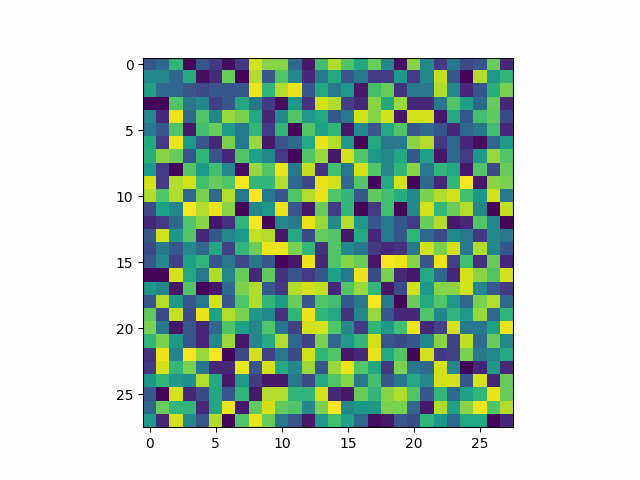

In [9]:
# Receptive field evolution

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image, display

idx_neuron = 23
weight_RF_evo = [weight[idx_neuron, :].reshape(28,28) for weight in weight_epoch_inhi]
weight_RF_evo = [weight_RF_evo[i] for i in range(0,len(weight_RF_evo),int(len(weight_RF_evo)/10)+1)]


fig = plt.figure()
ims = []
for x in range(len(weight_RF_evo)):
    im = plt.imshow(weight_RF_evo[x], animated=True)
    ims.append([im])


ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True)
ani.save('mnist_backup/animation_weight_RF_evo.gif', writer='imagemagick')


with open('mnist_backup/animation_weight_RF_evo.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))
    
plt.close()


# Test post training

In [10]:

X_train_batches, y_train_batches, X_test_batches, y_test_batches, nb_batch = load_mnist(nb_train=20, nb_test=20, working_range=3, batch_size_train=50,batch_size_test=50)
accuracy_max,confusion_matrix = model.final_evaluation(idx_epoch,X_test_batches[0], y_test_batches[0],noise=True,plot=debug)

print("\n accuracy_max = ", accuracy_max)

 ATTENTION ! you're currently using a reduced mnist (only 0|1|2|3)


WARNING    'v' is an internal variable of group 'input', but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'output', but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


len(y_train) =   24754
len(y_test) =   4157
X_train.shape, y_train.shape =  (20, 28, 28) (20,)
X_test.shape, y_test.shape =  (20, 28, 28) (20,)
For Training, with batch_size =  50  you got 1 batches of size : (20, 28, 28)
For Training, with batch_size =  50  you got 1 batches of size : (20, 28, 28)  
 

output_label_max =  1  and int(label) =  1
output_label_max =  3  and int(label) =  1
output_label_max =  3  and int(label) =  2
output_label_max =  2  and int(label) =  1
output_label_max =  2  and int(label) =  3
output_label_max =  1  and int(label) =  1
output_label_max =  2  and int(label) =  1
output_label_max =  1  and int(label) =  2

 accuracy_max =  0.4


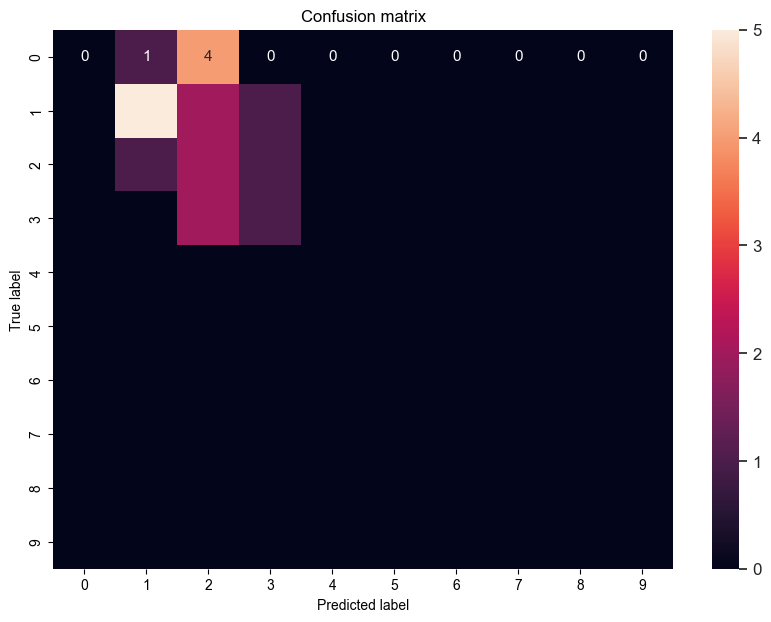

In [11]:
df_cm = pd.DataFrame(confusion_matrix, range(10), range(10))
plt.figure(figsize=(10,7))
plt.title("Confusion matrix")
sn.set(font_scale=1.1) # label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 11}) # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()